In [3]:
from DataUtils import DataInterface
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d;

%matplotlib inline

In [4]:
class SensorReader:
    def __init__(self, radiusOfEarth, encoder_resolution, encoder_diameterL, encoder_diameterR):
        self.data_interface = DataInterface(
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/gps.csv",
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/xsens_imu.csv",
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/encoder.csv"
        )
        # data -> (lon,lat,alt,left,right,yaw,pitch,roll)
        self.R = radiusOfEarth
        self.res = encoder_resolution
        self.angle_to_rad = np.pi/180
        self.enc_radL = encoder_diameterL / 2
        self.enc_radR = encoder_diameterR / 2
        
        self.init_data = self.parse(self.data_interface.read())
        self.meas = self.init_data.copy()
        self.meas[0:5] = 0 #re-init
        
    def parse(self, data):
        gps = data['gps_data']
        imu = data['imu_data']
        enc = data['encoders_data']
        lat,lon,alt = gps[1:4]
        pitch, roll, yaw = imu[5:8]
        left,right = enc[1:3]
        
        lat = lat*np.pi/180*R
        lon = lon*np.pi/180*R
        left = left * 2*np.pi/self.res * self.enc_radL
        right = right * 2*np.pi/self.res * self.enc_radR
        
        pitch = pitch * np.pi / 180
        yaw = yaw * np.pi / 180
        roll = roll * np.pi / 180
        return np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T
    def read(self):
        self.meas = self.parse(self.data_interface.read())
        self.meas[0:5] -= self.init_data[0:5]
        return self.meas

In [13]:
class KalmanFilter:
    def __init__(self, A,C,Q,R, init0):
        self.A = A
        self.C = C
        self.Q = Q
        self.R = R
        
        self.mu = init0
        self.cov = np.eye(3)
        self.Kt = np.eye(3)
    def predict(self):
        self.mu_pred = self.A @ self.mu
        self.cov_pred = self.A @ self.cov @ self.A.T + self.R
        self.Kt = self.cov_pred @ self.C.T @ np.linalg.inv(self.C @ self.cov_pred @ self.C.T + self.Q)
    def correct(self, meas):
        self.mu = self.mu_pred + self.Kt @ (meas - self.C @ self.mu_pred)
        self.cov = (np.eye(3) - self.Kt@self.C) @ self.cov_pred

In [14]:
A = np.eye(3)
Q = np.eye(3)
R = np.eye(3)
C = np.eye(3)


R = 6_371_000 #earth's radius in meters
encDiamL = 0.623022
encDiamR = 0.622356
res = 4096
wheelbase = 1.5285

sensors = SensorReader(R, res, encDiamL, encDiamR)

init0 = sensors.read()

In [15]:
print(init0[:3,:])

[[ 0.03335848]
 [-0.04447797]
 [ 0.062     ]]


In [16]:
kal = KalmanFilter(A,C,Q,R,init0[:3,:])

In [17]:
data = np.array([[0,0,0]]).T
sensor_data = np.array([[0,0,0]]).T
for i in range(5_000):
    reading = sensors.read()
    kal.predict()
    kal.correct(reading[:3,:])
    data = np.hstack((data,kal.mu))
    sensor_data = np.hstack((sensor_data, reading[:3,:]))

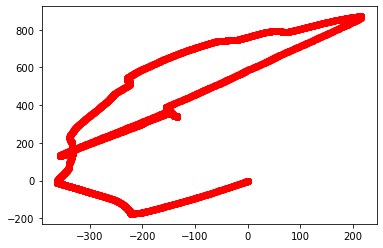

In [18]:
plt.scatter(data[0,:], data[1,:],c='red')
plt.show()